## Playing with FERC 1 Fuel data
This notebook is meant to help get you understand the data cleaning process for FERC Form 1 fuel data for heat content and price per MMBTU data.

### Importing external code.
We need to import a bunch of outside code to do our work here.  Sometimes we import entire packages (like `numpy` and `pandas`) and sometimes we just pull in a couple of pieces we need from a particular part of a large package (like `declarative_base`)

In [1]:
import sys
import os.path
import numpy as np
import pandas as pd
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from sqlalchemy.engine.url import URL
import matplotlib.pyplot as plt

### Importing our own code
We also need to tell Python where to look to find our own code.  It has a list of directories that it looks in, but our little project isn't in that list, unless we add it -- which is what `sys.path.append()` does.  You'll need to change this path to reflect where on your computer the PUDL project folder (which you pull down with `git`) lives.

Once Python knows to look in the `pudl` project folder, it will let you import `pudl` modules just like any other Python module.  Here we're pulling in the `ferc1` and `pudl` modules from the `pudl` package (which is a directory inside the `pudl` project directory).

In [2]:
sys.path.append('/Users/christinagosnell/code/pudl')
sys.path.append('/Users/zaneselvans/code/catalyst/pudl')
sys.path.append('/Users/Nannerz/Desktop/working/pudl/')
sys.path.append('/home/alana/Dropbox/catalyst/pudl')
from pudl import ferc1, pudl, models, models_ferc1, settings, constants

### Automatically reloading a work in progress
Because you're probably going to be editing the Python modules related to PUDL while you're working with this notebook, it's useful to have them get automatically reloaded before every cell is executed -- this means you're always using the freshest version of the module, with all your recent edits.

In [3]:
%load_ext autoreload
%autoreload 1
%aimport pudl.pudl
%aimport pudl.ferc1
%aimport pudl.constants
%aimport pudl.settings
%aimport pudl.models

### Connecting to our databases.
We have two different databases that we're working with right now.  The FERC Form 1 (`ferc1`) and our own PUDL database (`pudl`). For this software to work, you'll need to have the Postgresql database server running on your computer, and you'll need to have created empty databases to receive the tables and data we're going to create.  On a mac, the easiest Postgres install to get running is probably Postgress.app.  You'll need to fire it up at the command line at least once to create the databases (one called `ferc1` and another called `pudl_sandbox`) and a user named `catalyst` with no password.  This information is stored in the `settings` module if you need to look it up.

Here are two shortcuts for connecting to the two databases once they're created:

In [4]:
pudl_engine  = pudl.pudl.db_connect_pudl()
ferc1_engine = pudl.ferc1.db_connect_ferc1()

### Initializing the FERC Form 1 database
Now that you've got an empty database, let's put some data in it!  This function initializes the database by reading in the FERC Form 1 database structure from `refyear` and data from `years` (which can eventually be a list of years, but that's not working yet...). In order for this to work, you need to have the FERC Form 1 data downloaded into the data directory. There's a script called `get_ferc1.sh` down in `data/ferc/form1/` that will get it for you if you don't have it.

In [5]:
pudl.ferc1.init_db(refyear=2015, years=[2007,2008,2009,2010,2011,2012,2013,2014,2015], ferc1_tables=pudl.constants.ferc1_default_tables)

Defining new FERC Form 1 DB based on 2015...
Clearing any existing FERC Form 1 database MetaData...
Ingesting FERC Form 1 Data from 2007...
Ingesting FERC Form 1 Data from 2008...
Ingesting FERC Form 1 Data from 2009...
Ingesting FERC Form 1 Data from 2010...
Ingesting FERC Form 1 Data from 2011...
Ingesting FERC Form 1 Data from 2012...
Ingesting FERC Form 1 Data from 2013...
Ingesting FERC Form 1 Data from 2014...
Ingesting FERC Form 1 Data from 2015...


### Initializing the PUDL database
We'll pull in FERC 1 fuel, FERC 1 steam, and EIA 923's Fuel Receipts and Costs

In [6]:
pudl.pudl.init_db(ferc1_tables=['f1_fuel','f1_steam'], ferc1_years=[2007,2008,2009,2010,2011,2012,2013,2014,2015],\
                                  eia923_tables=['fuel_receipts_costs_eia923'], eia923_years=[2011,2012,2013,2014,2015], debug=True)

Ingesting static PUDL tables...
Sniffing EIA923/FERC1 glue tables...
Ingesting f1_fuel from FERC Form 1 into PUDL.
Ingesting f1_steam from FERC Form 1 into PUDL.
Reading EIA 923 spreadsheet data for 2011.
Reading EIA 923 spreadsheet data for 2012.
Reading EIA 923 spreadsheet data for 2013.
Reading EIA 923 spreadsheet data for 2014.
Reading EIA 923 spreadsheet data for 2015.
Converting EIA 923 fuel_receipts_costs for 2011 to DataFrame...
Converting EIA 923 fuel_receipts_costs for 2012 to DataFrame...
Converting EIA 923 fuel_receipts_costs for 2013 to DataFrame...
Converting EIA 923 fuel_receipts_costs for 2014 to DataFrame...
Converting EIA 923 fuel_receipts_costs for 2015 to DataFrame...
Ingesting fuel_receipts_costs_eia923 from EIA 923 into PUDL.


## Looking at average heat content per unit

### Pull applicable data from PUDL FERC tables

In [11]:
fuel_df = pd.read_sql('''SELECT * from fuel_ferc1''',pudl_engine)
coal = fuel_df[fuel_df.fuel=='coal']
gas = fuel_df[fuel_df.fuel=='gas']

In [16]:
coal.describe()

,id,respondent_id,report_year,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
count,2968.000000,2968.000000,2968.000000,2.968000e+03,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000,2968.000000
mean,6069.493598,120.564353,2010.881065,1.657573e+06,1.677774,84.904520,61.091692,39.022305,425.359838,31.795793
std,3511.121382,79.944562,2.531568,2.078680e+06,5.372426,1114.228979,807.926809,273.408754,1804.722527,517.292368
min,1.000000,1.000000,2007.000000,1.000000e+00,0.000000,0.000000,0.000000,0.000000,-325.000000,-18.832766
25%,3022.500000,55.000000,2009.000000,4.317305e+05,0.008657,31.375000,28.823750,1.746000,17.000000,9.598143
50%,6096.000000,127.000000,2011.000000,9.799950e+05,0.010582,42.958500,40.901000,2.266500,24.000000,10.312500
75%,9032.500000,178.000000,2013.000000,2.078284e+06,0.012073,62.953000,60.799750,2.989250,35.000000,10.911500
max,12256.000000,454.000000,2015.000000,4.641185e+07,28.722197,44033.320000,44033.320000,4181.493000,29179.000000,14033.000000


### Look at some median value, drop values below zero, and plot

In [17]:
coal.fuel_avg_mmbtu_per_unit.median()

0.0105815

In [14]:
coal_above_zero = coal[coal.fuel_avg_mmbtu_per_unit > 0]
coal_above_zero.shape

(2922, 13)

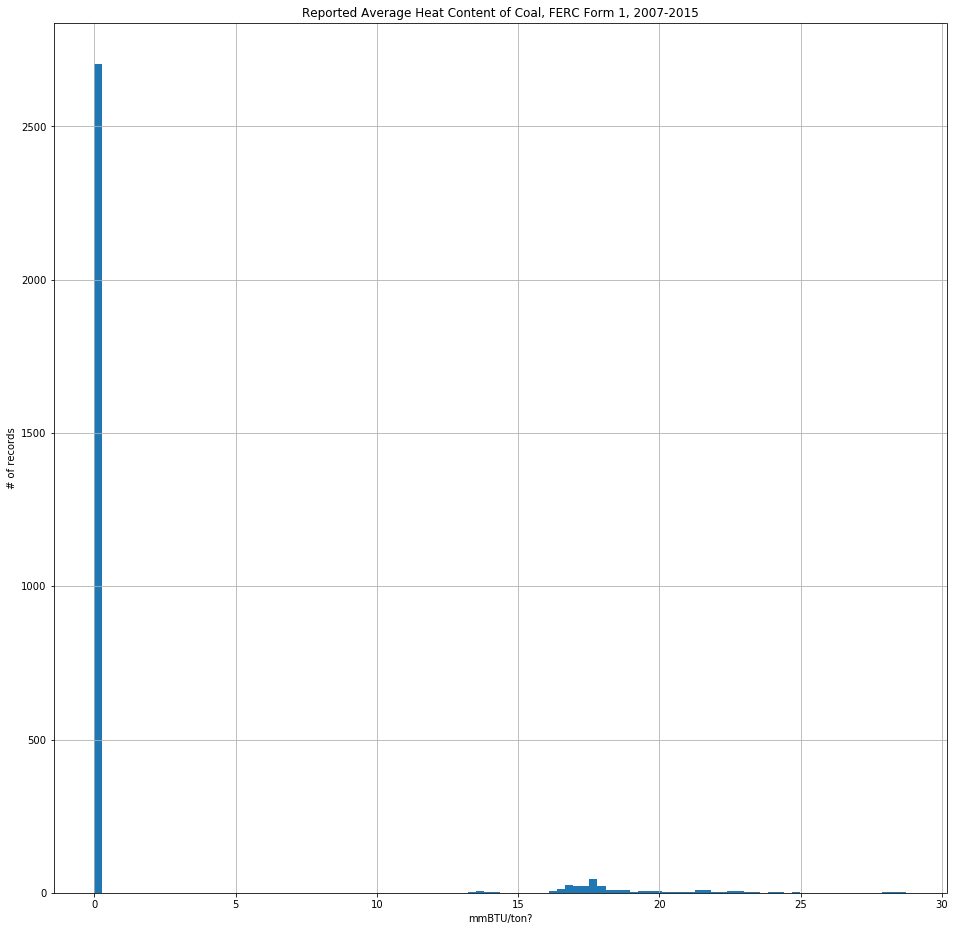

In [15]:
fig = plt.figure(figsize=(16,16))
plt.grid()
plt.title("Reported Average Heat Content of Coal, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/ton?")
plt.hist(coal.fuel_avg_mmbtu_per_unit, bins=100)
plt.show()

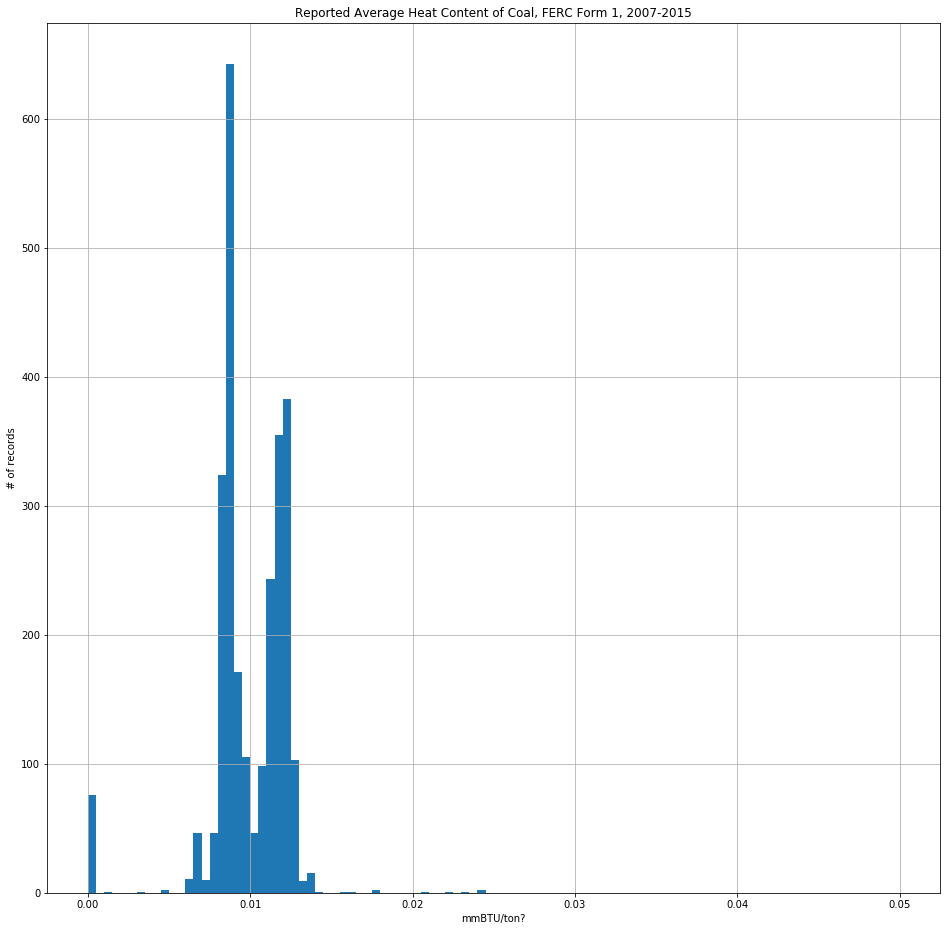

In [10]:
fig = plt.figure(figsize=(16,16))
plt.grid()
plt.title("Reported Average Heat Content of Coal, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/ton?")
plt.hist(coal.fuel_avg_mmbtu_per_unit, bins=100,range=(0,.05))
plt.show()

## Define a function for reported average heat content:

In [23]:
def coal_heat_content_correct(coal_df):
    
    coal_df = coal_df[coal_df.fuel_avg_mmbtu_per_unit > 0]
    df_copy = coal_df.copy()
# convert tons into pounds
    df_small = df_copy[(df_copy.fuel_avg_mmbtu_per_unit > .005) & \
                      (df_copy.fuel_avg_mmbtu_per_unit < .015)]
    df_small.fuel_avg_mmbtu_per_unit = df_small.fuel_avg_mmbtu_per_unit.apply(lambda x:x*2000)
# convert MMBTUs into BTUs    
    df_smaller = df_copy[(df_copy.fuel_avg_mmbtu_per_unit > .000010) & \
                      (df_copy.fuel_avg_mmbtu_per_unit < .000030)]
    df_smaller.fuel_avg_mmbtu_per_unit = df_smaller.fuel_avg_mmbtu_per_unit.apply(lambda x:x*1e6)
#convert tons into pounds and MMBTUs into BTUs    
    df_smallest = df_copy[(df_copy.fuel_avg_mmbtu_per_unit > .005e-6) & \
                      (df_copy.fuel_avg_mmbtu_per_unit < .015e-6)]
    df_smallest.fuel_avg_mmbtu_per_unit = df_smallest.fuel_avg_mmbtu_per_unit.apply(lambda x:x*2000e6)
    
    coal_df = coal_df.drop(coal_df[(coal_df.fuel_avg_mmbtu_per_unit > .005) & \
                      (coal_df.fuel_avg_mmbtu_per_unit < .015)].index)
    coal_df = coal_df.drop(coal_df[(coal_df.fuel_avg_mmbtu_per_unit > .000010) & \
                      (coal_df.fuel_avg_mmbtu_per_unit < .000030)].index)
    coal_df = coal_df.drop(coal_df[(df_copy.fuel_avg_mmbtu_per_unit > .005e-6) & \
                      (coal_df.fuel_avg_mmbtu_per_unit < .015e-6)].index)
    
    coal_df = coal_df.append(df_small)
    coal_df = coal_df.append(df_smaller)
    coal_df = coal_df.append(df_smallest)

    return coal_df

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:17: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


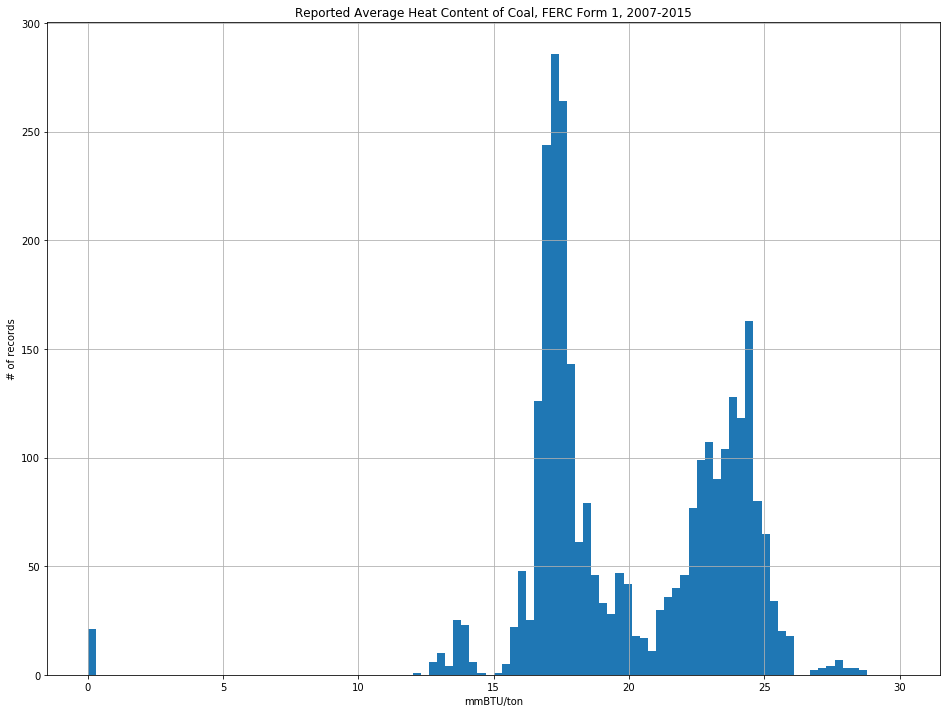

In [43]:
to_plot = coal_heat_content_correct(coal)

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Average Heat Content of Coal, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/ton")

plt.hist(to_plot.fuel_avg_mmbtu_per_unit, bins=100, range=(0,30))
plt.show()

### Verify same number of records are in the new dataframe, look at outliers on the low end - should we adjust the range of values being altered?

In [25]:
to_plot.describe()

,id,respondent_id,report_year,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
count,2922.000000,2922.000000,2922.000000,2.922000e+03,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000,2922.000000
mean,6070.301164,121.440110,2010.885352,1.658541e+06,20.042881,84.547871,60.424721,39.560376,431.580424,32.165930
std,3529.109583,79.936251,2.546022,2.079391e+06,3.737284,1122.932130,814.192791,275.518264,1818.177031,521.340724
min,1.000000,1.000000,2007.000000,1.000000e+00,0.000009,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3019.500000,55.000000,2009.000000,4.325988e+05,17.279500,31.205750,28.767250,1.741250,17.000000,9.592467
50%,6093.000000,127.000000,2011.000000,9.834255e+05,18.994000,42.686000,40.724500,2.255500,24.000000,10.318842
75%,9089.500000,178.000000,2013.000000,2.076565e+06,23.506500,61.814250,59.742000,2.959500,34.000000,10.927750
max,12256.000000,454.000000,2015.000000,4.641185e+07,28.722197,44033.320000,44033.320000,4181.493000,29179.000000,14033.000000


In [37]:
to_plot.fuel_avg_mmbtu_per_unit.nsmallest(30)

2547      0.000009
792       0.000010
794       0.000010
1896      0.001270
6123      0.003333
11016     0.004795
11568     0.004941
4003      0.015560
11497     0.016284
1058      0.017577
1055      0.017590
9325      0.020992
6614      0.022144
7460      0.023181
6612      0.024250
7458      0.024341
2104      0.135007
2108      0.136267
2102      0.139073
2105      0.144287
2103      0.145059
10403    12.180000
3078     12.742000
4289     12.772000
396      12.814000
5751     12.862000
5654     12.864000
2067     12.876000
5128     12.928000
11299    12.932000
Name: fuel_avg_mmbtu_per_unit, dtype: float64

## Now let's take a look at reported average heat content for natural gas

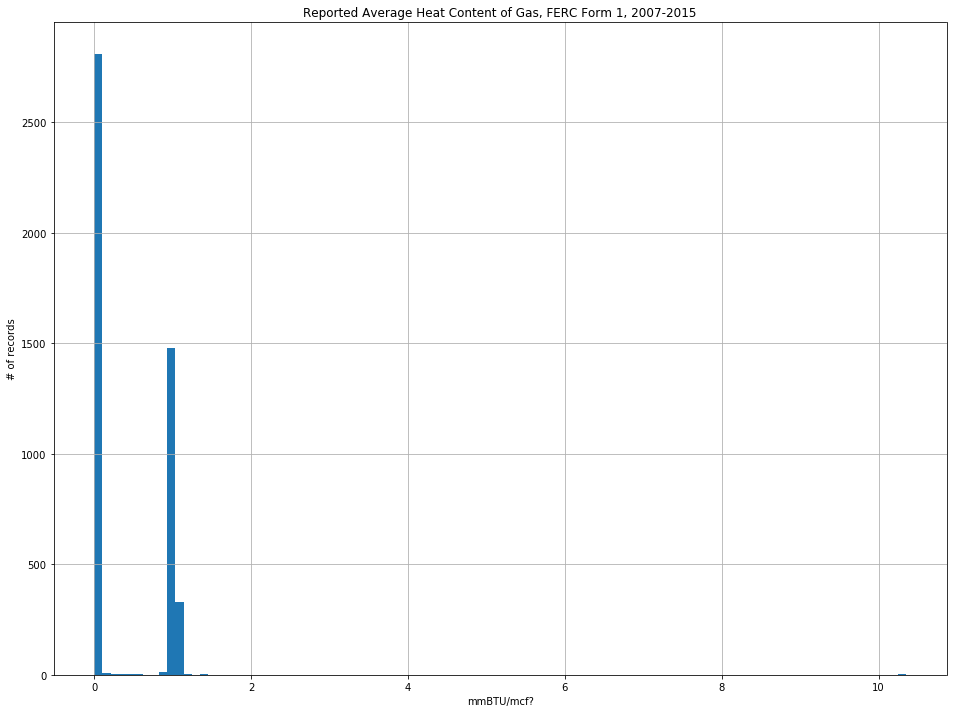

In [29]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Average Heat Content of Gas, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/mcf?")
plt.hist(gas.fuel_avg_mmbtu_per_unit, bins=100)
plt.show()

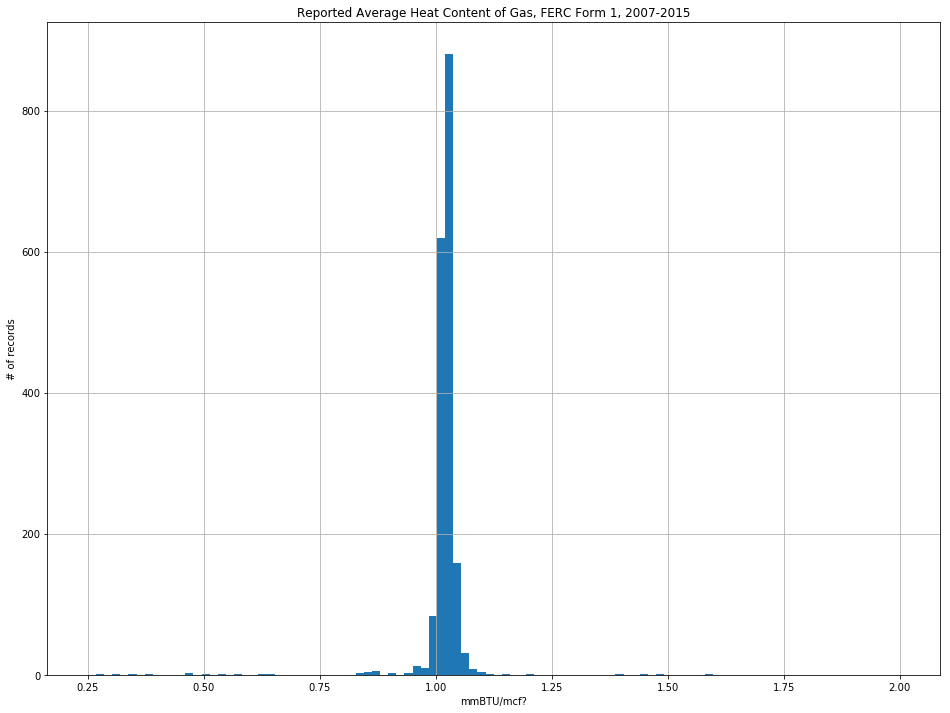

In [26]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Average Heat Content of Gas, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/mcf?")
plt.hist(gas.fuel_avg_mmbtu_per_unit, bins=100, range=(.25,2))
plt.show()

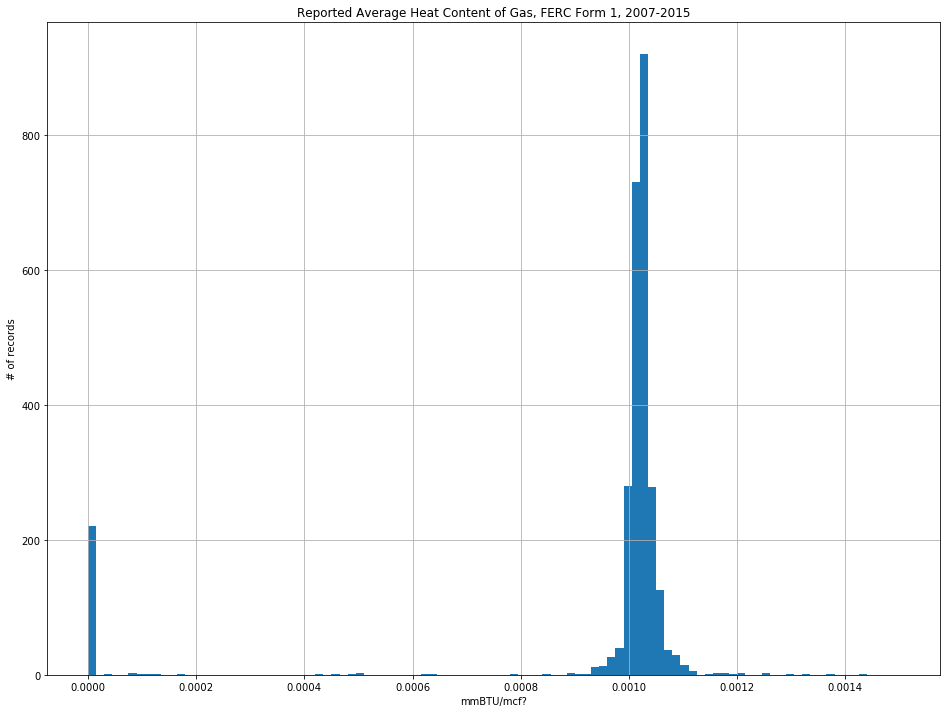

In [27]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Average Heat Content of Gas, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/mcf?")
plt.hist(gas.fuel_avg_mmbtu_per_unit, bins=100, range=(0,.0015))
plt.show()

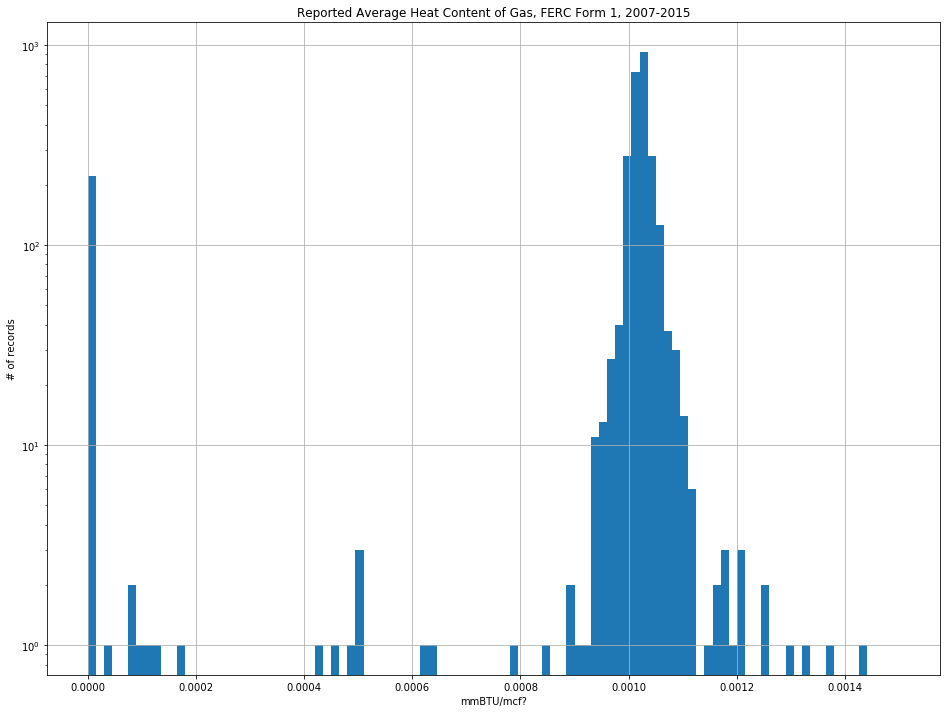

In [42]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Average Heat Content of Gas, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/mcf?")
plt.hist(gas.fuel_avg_mmbtu_per_unit, bins=100, range=(0,.0015),log=True)
plt.show()

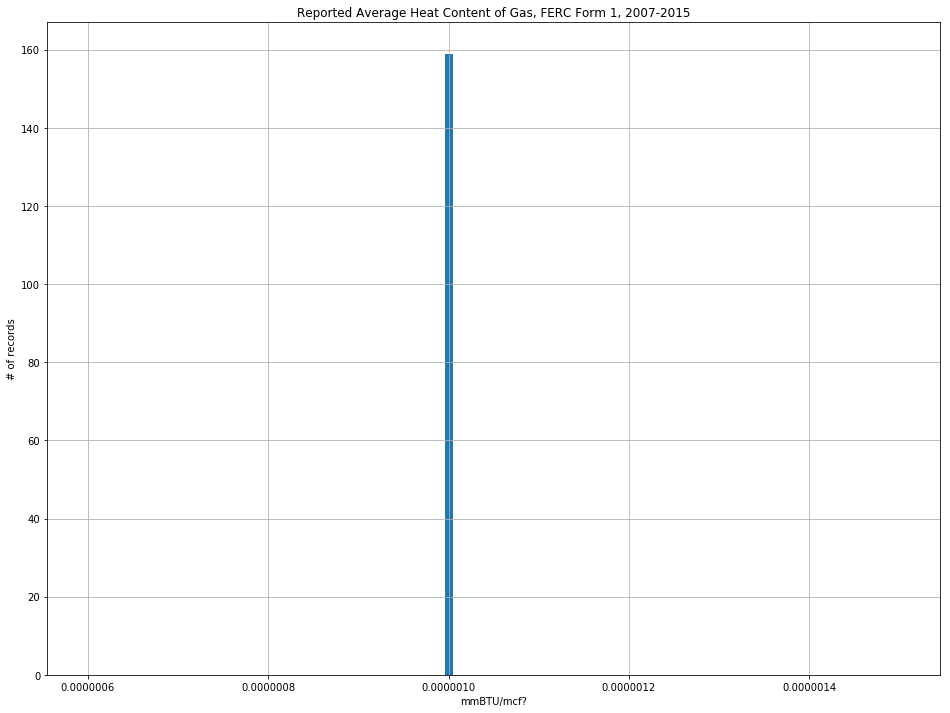

In [28]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Average Heat Content of Gas, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/mcf?")
plt.hist(gas.fuel_avg_mmbtu_per_unit, bins=100, range=(.0000006,.0000015))
plt.show()

In [487]:
gas.fuel_avg_mmbtu_per_unit.describe()

,id,respondent_id,report_year,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
count,4606.000000,4606.000000,4606.000000,4.606000e+03,4606.000000,4606.000000,4606.000000,4606.000000,4.606000e+03,4606.000000
mean,6293.389926,125.960269,2011.016717,5.035207e+06,0.419277,15.144275,13.417746,98.859018,2.657711e+03,43.027281
std,3550.394834,74.477576,2.572793,1.438293e+07,0.571257,254.224447,238.917891,743.543080,3.185912e+04,1186.830190
min,2.000000,1.000000,2007.000000,7.000000e+00,0.000001,-150.442000,-72.231000,-527.687000,-1.198000e+06,-53277.000000
25%,3263.250000,56.000000,2009.000000,4.870775e+04,0.001017,4.489250,3.865000,4.370000,2.700000e+01,0.000000
50%,6399.500000,134.000000,2011.000000,3.442620e+05,0.001040,5.733000,5.300000,5.696000,6.000000e+01,7.986500
75%,9451.750000,177.000000,2013.000000,3.184716e+06,1.019000,8.180000,7.643000,8.297250,1.100000e+02,12.923978
max,12261.000000,454.000000,2015.000000,5.093491e+08,10.348000,10670.000000,10670.000000,12842.767000,1.238852e+06,43535.000000


In [489]:
gas.fuel_avg_mmbtu_per_unit.median()

0.00104

### Define a function to bring the 3 outlying populations into the main population

In [30]:
def gas_heat_content_correct(gas_df):
    
    gas_df = gas_df[gas_df.fuel_avg_mmbtu_per_unit > 0]
    
    df_copy = gas_df.copy()
# convert from MMBTU/cf to MMBTU/mcf 
    df_small = df_copy[(df_copy.fuel_avg_mmbtu_per_unit > .00075) & \
                      (df_copy.fuel_avg_mmbtu_per_unit < .00125)]
    df_small.fuel_avg_mmbtu_per_unit = df_small.fuel_avg_mmbtu_per_unit.apply(lambda x:x*1000)
    df_small.fuel_unit = 'mcf'
# convert BTU/mcf into MMBTU/mcf    
    df_smaller = df_copy[(df_copy.fuel_avg_mmbtu_per_unit > .0000007) & \
                      (df_copy.fuel_avg_mmbtu_per_unit < .00000125)] 
    df_smaller.fuel_avg_mmbtu_per_unit = df_smaller.fuel_avg_mmbtu_per_unit.apply(lambda x:x*1e6)
    df_smaller.fuel_unit = 'mcf'
    
    gas_df = gas_df.drop(gas_df[(gas_df.fuel_avg_mmbtu_per_unit > .00075) & \
                      (gas_df.fuel_avg_mmbtu_per_unit < .00125)].index)
    gas_df = gas_df.drop(gas_df[(gas_df.fuel_avg_mmbtu_per_unit > .0000007) & \
                      (gas_df.fuel_avg_mmbtu_per_unit < .00000125)].index)

    gas_df = gas_df.append(df_small)
    gas_df = gas_df.append(df_smaller)
    
    return gas_df

gas_1 = gas_heat_content_correct(gas)

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### Verify the same number of records are in the new dataframe, look at outliers on the high and low end. The low end has quite a few -  could there be another population or two?

In [31]:
gas_1.describe()

,id,respondent_id,report_year,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
count,4606.000000,4606.000000,4606.000000,4.606000e+03,4606.000000,4606.000000,4606.000000,4606.000000,4.606000e+03,4606.000000
mean,6293.389926,125.960269,2011.016717,5.035207e+06,1.015186,15.144275,13.417746,98.859018,2.657711e+03,43.027281
std,3550.394834,74.477576,2.572793,1.438293e+07,0.284638,254.224447,238.917891,743.543080,3.185912e+04,1186.830190
min,2.000000,1.000000,2007.000000,7.000000e+00,0.000003,-150.442000,-72.231000,-527.687000,-1.198000e+06,-53277.000000
25%,3263.250000,56.000000,2009.000000,4.870775e+04,1.010000,4.489250,3.865000,4.370000,2.700000e+01,0.000000
50%,6399.500000,134.000000,2011.000000,3.442620e+05,1.021000,5.733000,5.300000,5.696000,6.000000e+01,7.986500
75%,9451.750000,177.000000,2013.000000,3.184716e+06,1.030344,8.180000,7.643000,8.297250,1.100000e+02,12.923978
max,12261.000000,454.000000,2015.000000,5.093491e+08,10.348000,10670.000000,10670.000000,12842.767000,1.238852e+06,43535.000000


In [521]:
gas_1.fuel_avg_mmbtu_per_unit.median()

1.021

In [40]:
gas_1.fuel_avg_mmbtu_per_unit.nlargest(30)

3994     10.348000
7802     10.272000
2441     10.201000
838       5.834000
1606      5.368698
11073     2.225805
11074     2.101174
10962     2.049441
11072     1.596805
11050     1.492380
12231     1.442920
10996     1.395020
9949      1.245000
10079     1.209000
8902      1.208000
7579      1.204000
1854      1.202697
4291      1.200000
1677      1.180000
4211      1.175000
2832      1.174000
3282      1.169000
179       1.160000
8501      1.142937
7585      1.141000
8572      1.120000
940       1.114000
10077     1.114000
10089     1.114000
11320     1.114000
Name: fuel_avg_mmbtu_per_unit, dtype: float64

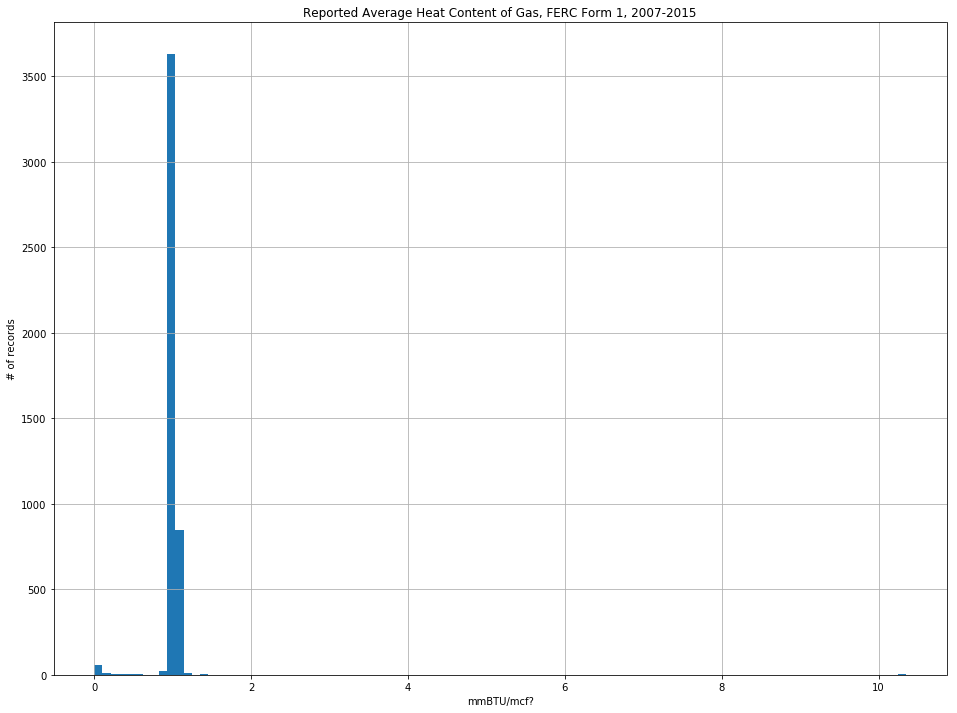

In [32]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Average Heat Content of Gas, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/mcf?")
plt.hist(gas_1.fuel_avg_mmbtu_per_unit, bins=100)
plt.show()

In [41]:
gas_1.fuel_avg_mmbtu_per_unit.nsmallest(40)

3896     0.000003
6629     0.000038
12034    0.000080
10202    0.000083
6382     0.000091
11787    0.000108
11288    0.000120
11986    0.000170
7792     0.000430
6130     0.000464
11753    0.000485
9186     0.000500
10747    0.000500
11909    0.000500
9791     0.000622
10190    0.000635
11292    0.001254
9147     0.001300
2060     0.001325
10350    0.001375
5655     0.001432
10402    0.001589
2101     0.001647
11310    0.001755
538      0.001756
4720     0.002142
6142     0.004234
2949     0.005278
5158     0.006082
7061     0.008482
9732     0.010000
9520     0.013372
2951     0.051949
1097     0.091044
1100     0.091044
753      0.091500
2314     0.091500
5133     0.091500
6595     0.091500
10827    0.091500
Name: fuel_avg_mmbtu_per_unit, dtype: float64

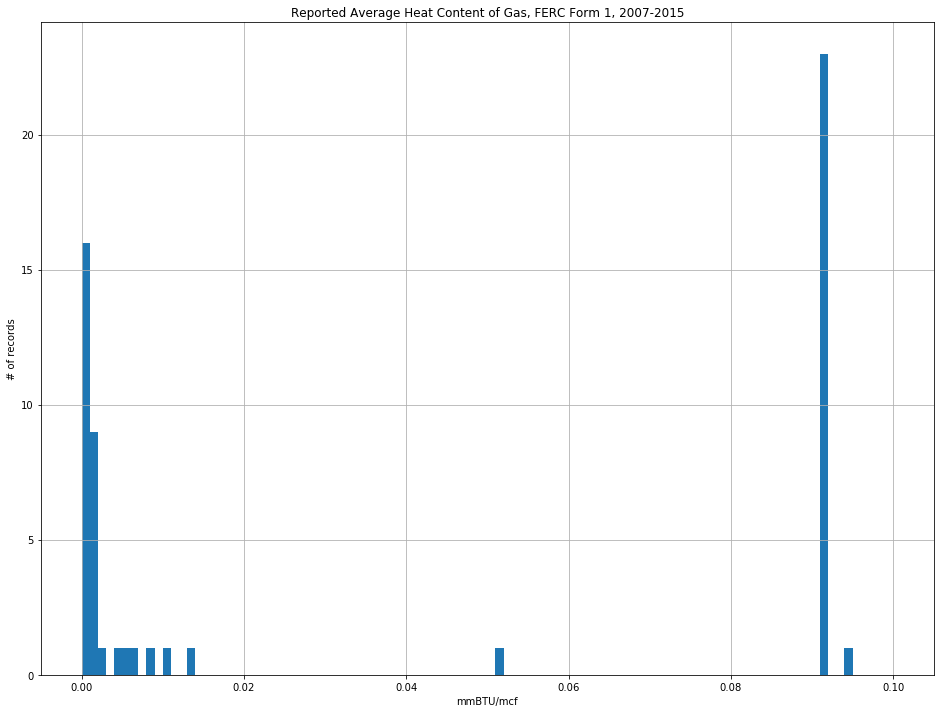

In [35]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Average Heat Content of Gas, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/mcf")
plt.hist(gas_1.fuel_avg_mmbtu_per_unit, bins=100, range=(0,.1))
plt.show()

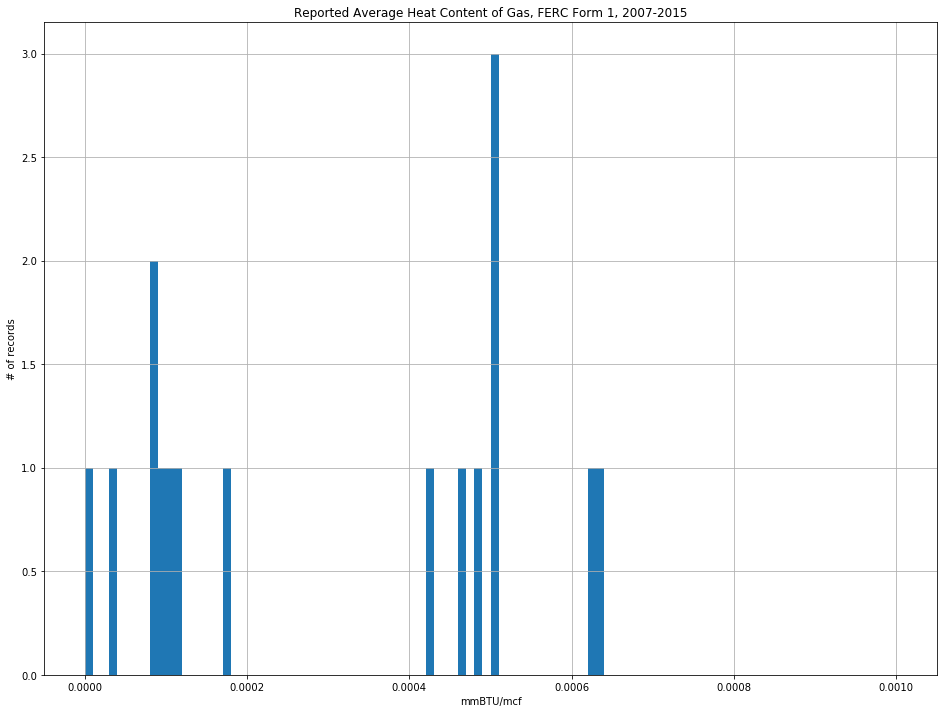

In [34]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Average Heat Content of Gas, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("mmBTU/mcf")
plt.hist(gas_1.fuel_avg_mmbtu_per_unit, bins=100, range=(0,.001))
plt.show()

In [554]:
gas_1.fuel_unit.value_counts()

mcf      4567
bbl        17
mmbtu      12
gal         9
ton         1
Name: fuel_unit, dtype: int64

## Let's look into cost per mmbtu for coal and gas

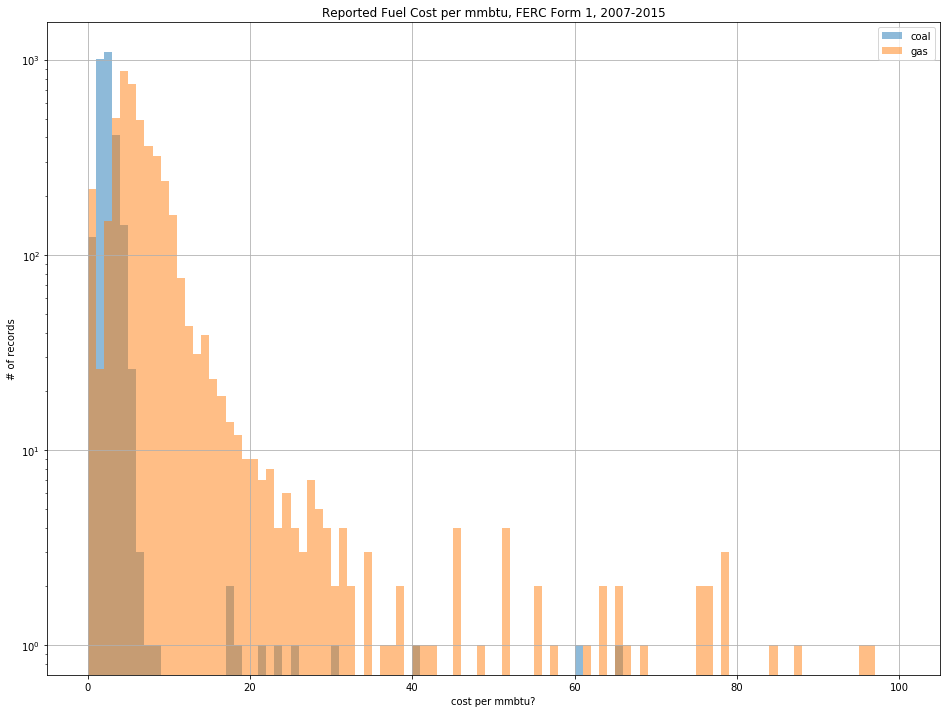

In [78]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist(coal.fuel_cost_per_mmbtu, bins=100,range=(0,100),alpha=.5,log=True,label=['coal'])
plt.hist(gas.fuel_cost_per_mmbtu, bins=100,range=(0,100),alpha=.5,log=True,label=['gas'])
plt.legend()
plt.show()

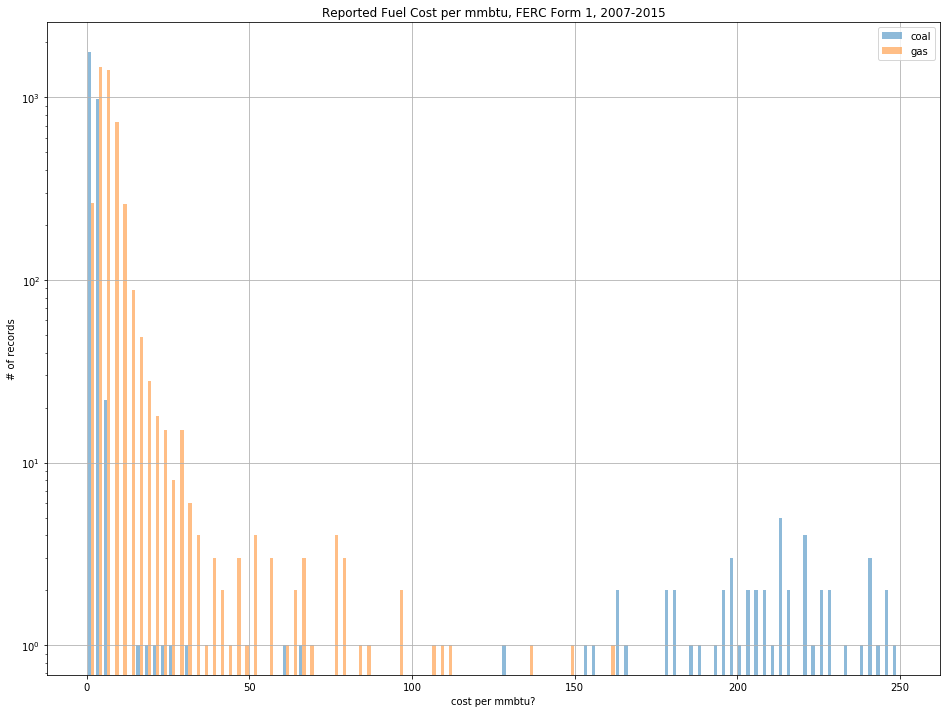

In [656]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal.fuel_cost_per_mmbtu,gas.fuel_cost_per_mmbtu], bins=100,range=(0,250),alpha=.5,log=True,label=['coal','gas'])
plt.legend()
plt.show()

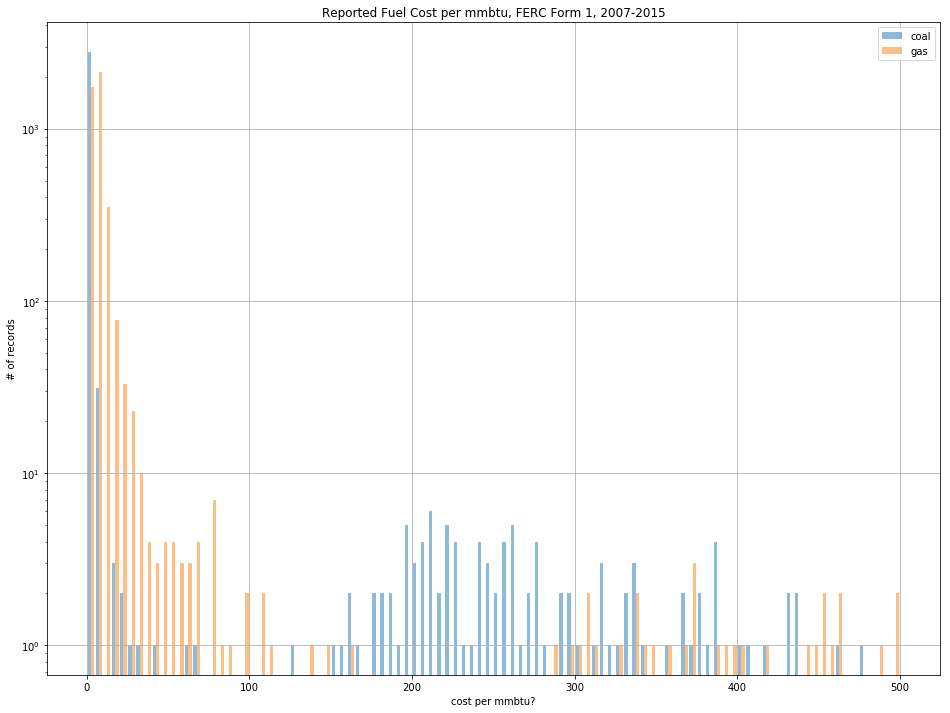

In [684]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal.fuel_cost_per_mmbtu,gas.fuel_cost_per_mmbtu], bins=100,range=(0,500),alpha=.5,log=True,label=['coal','gas'])
plt.legend()
plt.show()

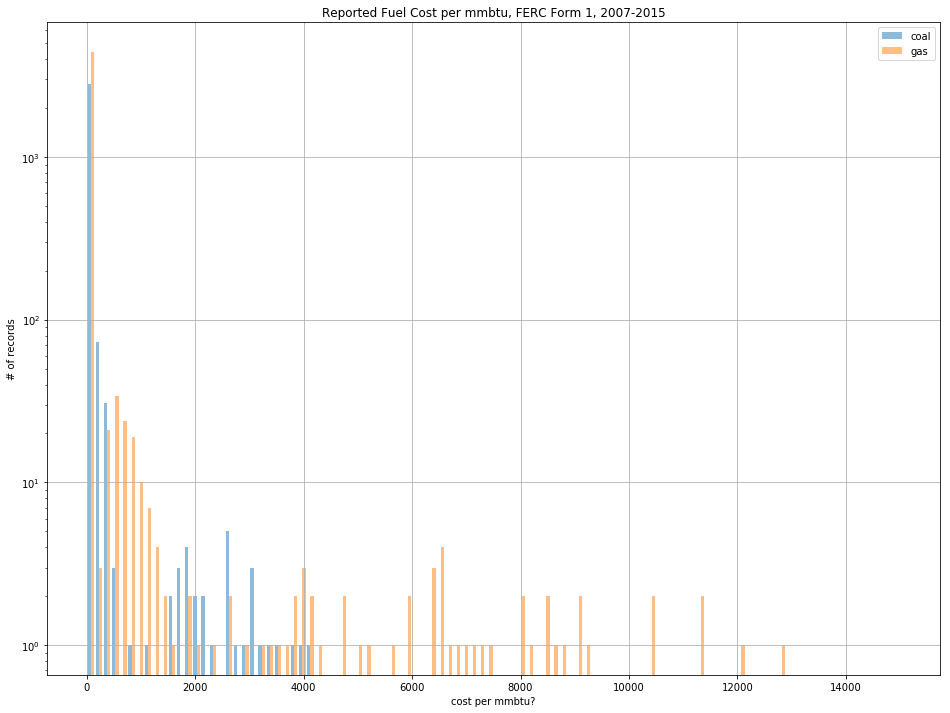

In [688]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal.fuel_cost_per_mmbtu,gas.fuel_cost_per_mmbtu], bins=100,range=(0,15000),alpha=.5,log=True,label=['coal','gas'])
plt.legend()
plt.show()

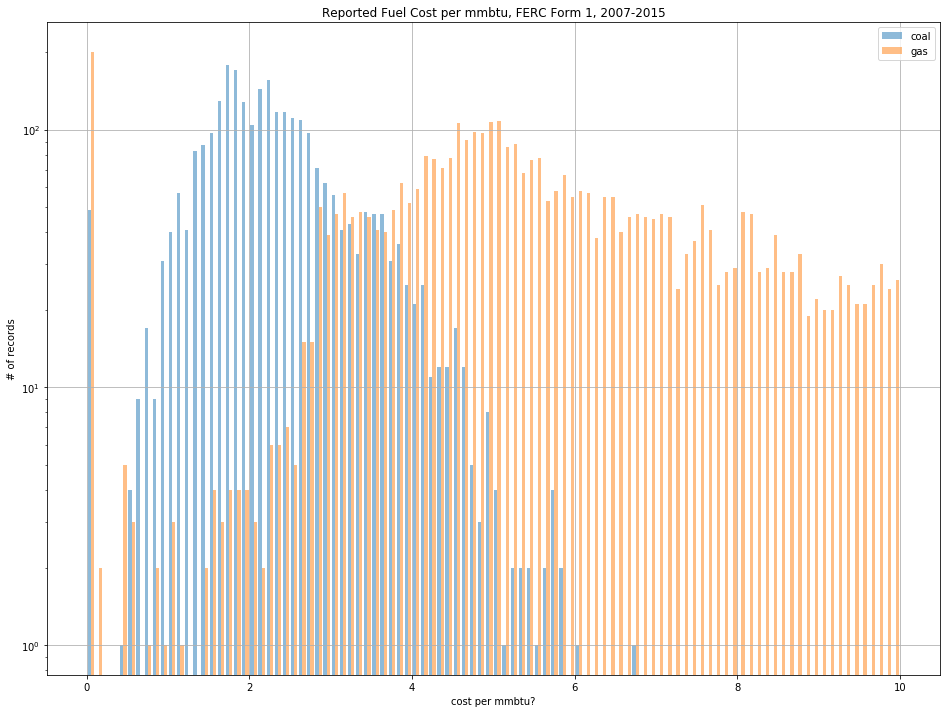

In [657]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal.fuel_cost_per_mmbtu,gas.fuel_cost_per_mmbtu], bins=100,range=(0,10),alpha=.5,log=True,label=['coal','gas'])
plt.legend()
plt.show()

## Look into gas cost per MMBTU specifically

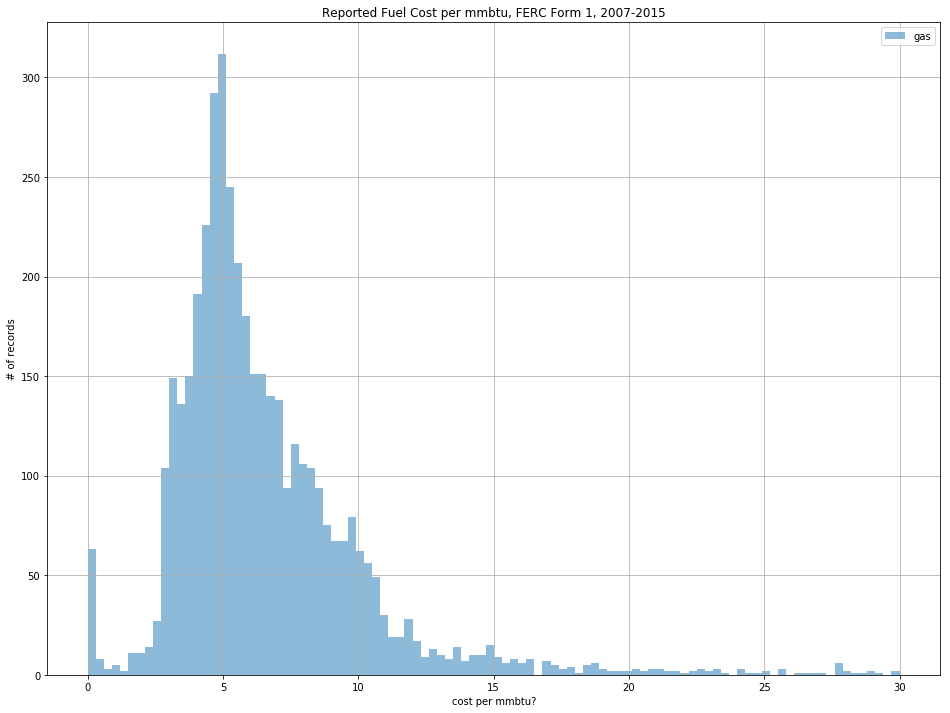

In [682]:
gas_no_zero = gas[gas.fuel_cost_per_mmbtu > 0]

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([gas_no_zero.fuel_cost_per_mmbtu], bins=100,range=(0,30),alpha=.5,label=['gas'])
plt.legend()
plt.show()

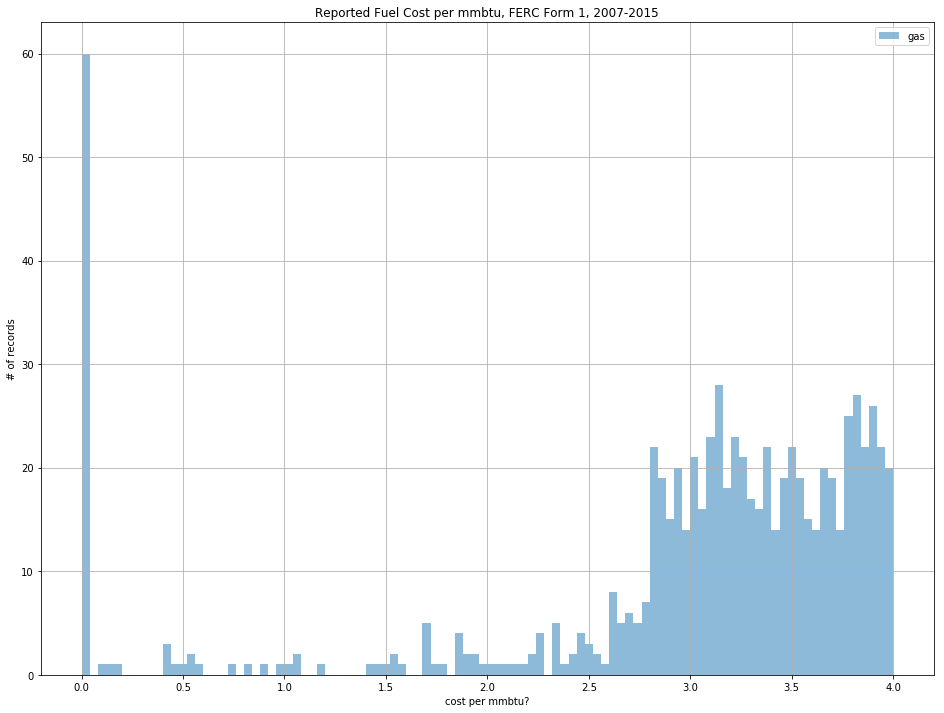

In [45]:
gas_no_zero = gas[gas.fuel_cost_per_mmbtu > 0]

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([gas_no_zero.fuel_cost_per_mmbtu], bins=100,range=(0,4),alpha=.5,label=['gas'])
plt.legend()
plt.show()

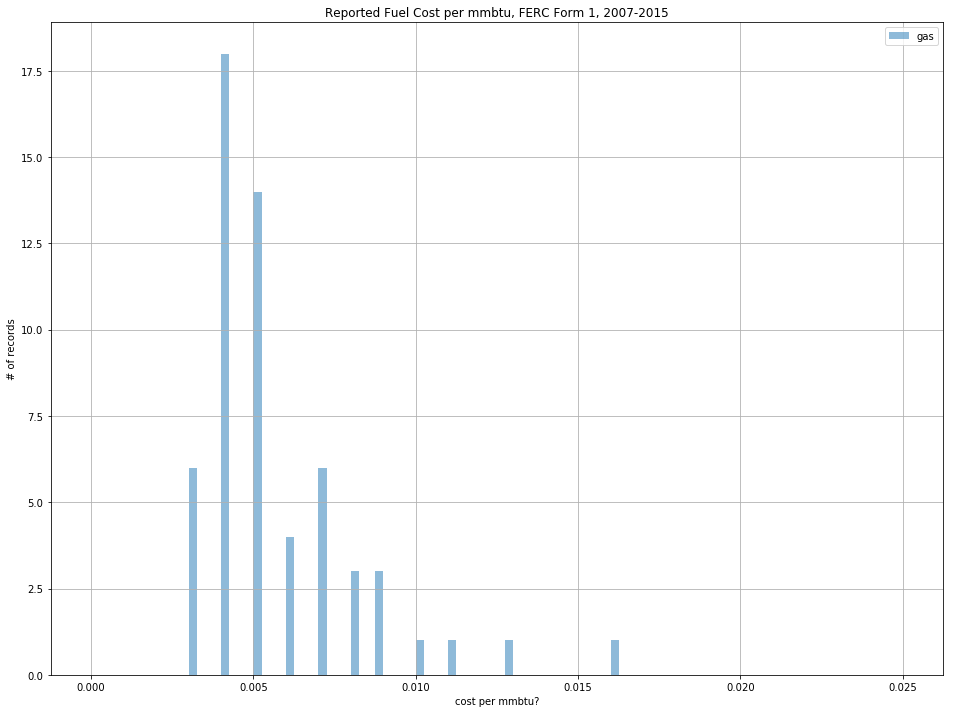

In [759]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([gas_no_zero.fuel_cost_per_mmbtu], bins=100,range=(0,.025),alpha=.5,label=['gas'])
plt.legend()
plt.show()

In [664]:
gas_no_zero.fuel_cost_per_mmbtu.min()

0.0030000000000000001

In [52]:
gas_no_zero.sort_values(by='fuel_cost_per_mmbtu',inplace=True)
gas_no_zero.fuel_cost_per_mmbtu.tail(20)

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


2044     7013.436
1063     7054.445
2034     7283.169
746      7398.395
2318     7951.875
2049     7986.314
2039     8119.618
2042     8416.740
2041     8521.517
2101     8625.111
2035     8719.914
1074     9057.531
2046     9103.192
2047     9230.792
5828    10386.000
2038    10400.483
2048    11252.545
3282    11388.840
2094    12097.974
2045    12842.767
Name: fuel_cost_per_mmbtu, dtype: float64

In [678]:
gas_no_zero.sort_values(by='fuel_cost_per_mmbtu',inplace=True)
gas_no_zero.fuel_cost_per_mmbtu.head(70)

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


12260    0.003
8092     0.003
8091     0.003
8088     0.003
12259    0.003
8084     0.003
8536     0.004
12252    0.004
5039     0.004
8540     0.004
2877     0.004
2876     0.004
8539     0.004
6475     0.004
1610     0.004
6474     0.004
8532     0.004
2867     0.004
2871     0.004
8083     0.004
8089     0.004
2873     0.004
10028    0.004
2874     0.004
6472     0.005
6471     0.005
6467     0.005
12256    0.005
10027    0.005
5031     0.005
         ...  
1059     0.006
10020    0.006
1060     0.007
1051     0.007
10025    0.007
1053     0.007
1606     0.007
1062     0.007
12257    0.008
10251    0.008
1601     0.008
1600     0.009
1607     0.009
1609     0.009
1604     0.010
10026    0.011
943      0.013
10021    0.016
10077    0.036
11321    0.036
2956     0.090
2951     0.143
11446    0.168
6781     0.400
9697     0.418
135      0.420
3609     0.440
2032     0.480
9186     0.530
10747    0.535
Name: fuel_cost_per_mmbtu, dtype: float64

In [56]:
gas_no_zero.shape

(4514, 13)

### Define a function for coal cost per mmbtu cleaning

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


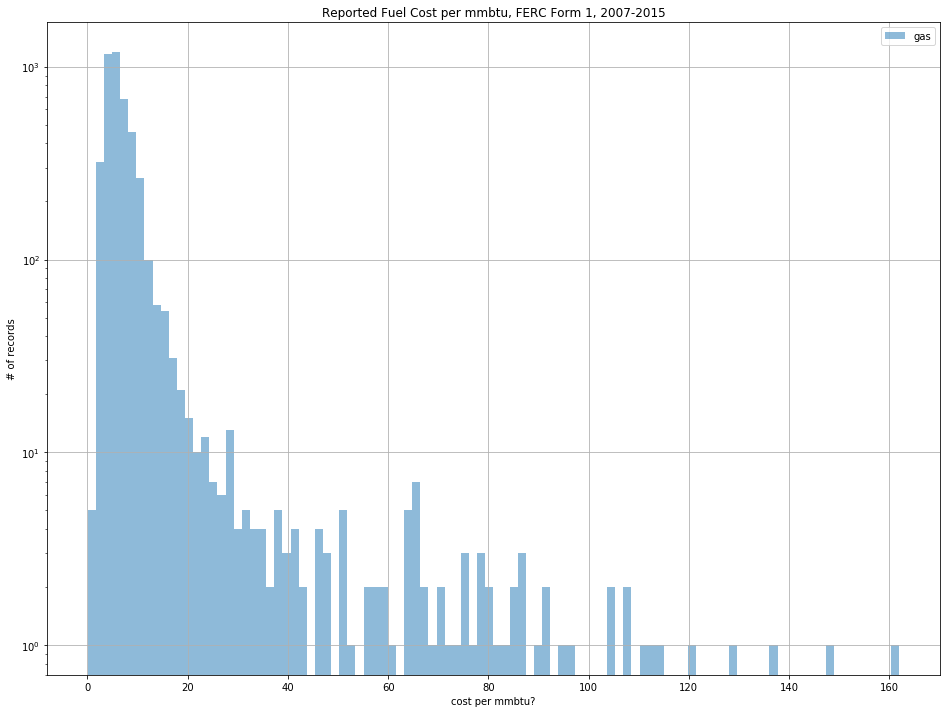

In [68]:
def gas_cost_per_mmbtu_correct(gas_df):
    
    gas_df = gas_df[gas_df.fuel_cost_per_mmbtu > 0]
    
    df_copy = gas_df.copy()
# convert from cents per MMBTU to dollars per MMBTU
    df_cents_to_dollars = df_copy[(df_copy.fuel_cost_per_mmbtu > 250) & \
                      (df_copy.fuel_cost_per_mmbtu < 17500)]
    df_cents_to_dollars.fuel_cost_per_mmbtu = df_cents_to_dollars.fuel_cost_per_mmbtu.apply(lambda x:x / 100)
# convert from dollars per cf to dollars per mcf - we should look at quantity of fuel burned   
    small_df = df_copy[(df_copy.fuel_cost_per_mmbtu > .0025) & \
                      (df_copy.fuel_cost_per_mmbtu < .0175)]
    small_df.fuel_cost_per_mmbtu = small_df.fuel_cost_per_mmbtu.apply(lambda x: x * 1000)
    
#convert from cents per cf to dollars per mcf
    cents_cf_df = df_copy[(df_copy.fuel_cost_per_mmbtu > .25) & \
                      (df_copy.fuel_cost_per_mmbtu < 1.75)]
    cents_cf_df.fuel_cost_per_mmbtu = cents_cf_df.fuel_cost_per_mmbtu.apply(lambda x: x * 10) 
    
    gas_df = gas_df.drop(gas_df[(gas_df.fuel_cost_per_mmbtu > 250) & \
                      (gas_df.fuel_cost_per_mmbtu < 17500)].index)
    
    gas_df = gas_df.drop(gas_df[(gas_df.fuel_cost_per_mmbtu > .0025) & \
                      (gas_df.fuel_cost_per_mmbtu < .0175)].index)
    
    gas_df = gas_df.drop(gas_df[(gas_df.fuel_cost_per_mmbtu > .25) & \
                      (gas_df.fuel_cost_per_mmbtu < 1.75)].index)

    gas_df = gas_df.append(df_cents_to_dollars)
    gas_df = gas_df.append(small_df)
    gas_df = gas_df.append(cents_cf_df)
    
    return gas_df

gas_cost_per_mmbtu_correct_1 = gas_cost_per_mmbtu_correct(gas)

gas_cost_per_mmbtu_correct_1

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist(gas_cost_per_mmbtu_correct_1.fuel_cost_per_mmbtu, bins=100,alpha=.5,log=True,label=['gas'])
plt.legend()
plt.show()

### There are still some value near .1. Should we widen the range of values to capture them?

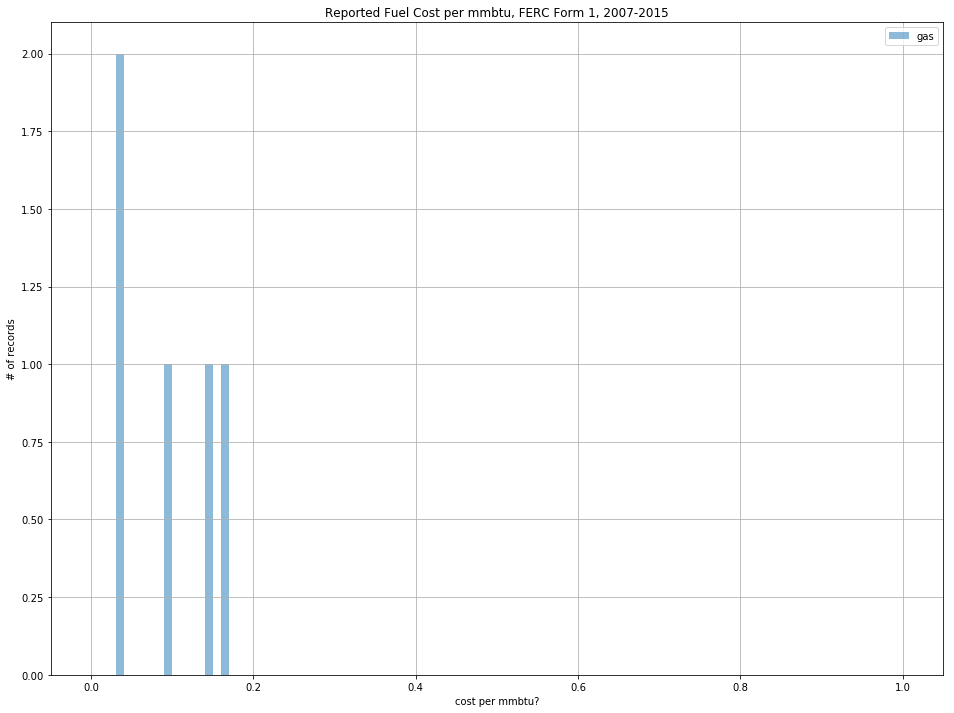

In [79]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([gas_cost_per_mmbtu_correct_1.fuel_cost_per_mmbtu], bins=100,alpha=.5,range=(0,1),label=['gas'])
plt.legend()
plt.show()

In [80]:
gas_cost_per_mmbtu_correct_1.fuel_cost_per_mmbtu.nsmallest(30)

10077    0.036
11321    0.036
2956     0.090
2951     0.143
11446    0.168
554      1.780
11101    1.844
5008     1.860
5010     1.860
3284     1.879
11114    1.900
6384     1.910
10089    1.920
9513     1.925
3867     1.965
12063    2.039
3612     2.040
12034    2.080
11160    2.140
1255     2.192
6479     2.200
3688     2.213
11125    2.260
3547     2.266
6477     2.270
8269     2.275
8248     2.320
12060    2.333
11050    2.344
3955     2.346
Name: fuel_cost_per_mmbtu, dtype: float64

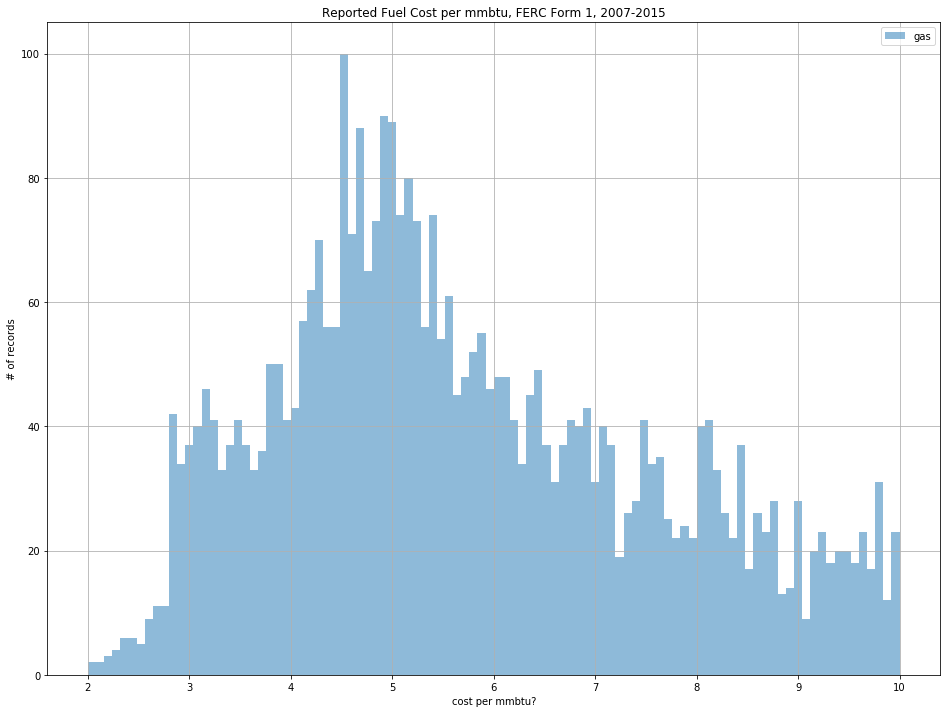

In [755]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([gas_cost_per_mmbtu_correct_1.fuel_cost_per_mmbtu], bins=100,alpha=.5,range=(2,10),label=['gas'])
plt.legend()
plt.show()

## Looking at coal cost per MMBTU specifically

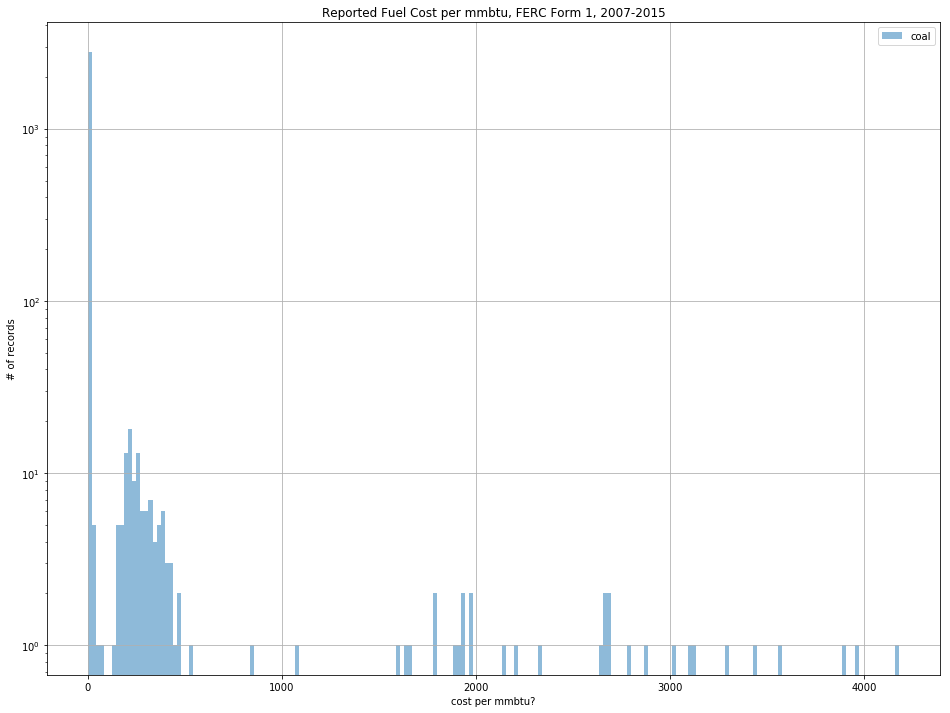

In [731]:
coal_no_zero = coal[coal.fuel_cost_per_mmbtu > 0]

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal_no_zero.fuel_cost_per_mmbtu], bins=200,alpha=.5,label=['coal'],log=True)
plt.legend()
plt.show()

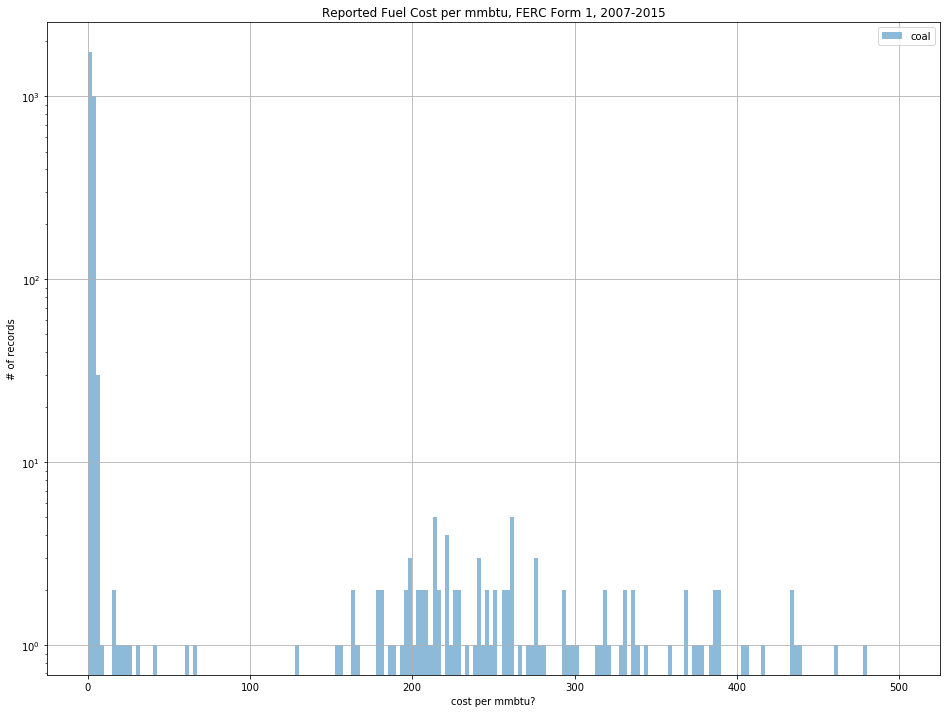

In [720]:
coal_no_zero = coal[coal.fuel_cost_per_mmbtu > 0]

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal_no_zero.fuel_cost_per_mmbtu], bins=200,alpha=.5,label=['coal'],log=True,range=(0,500))
plt.legend()
plt.show()

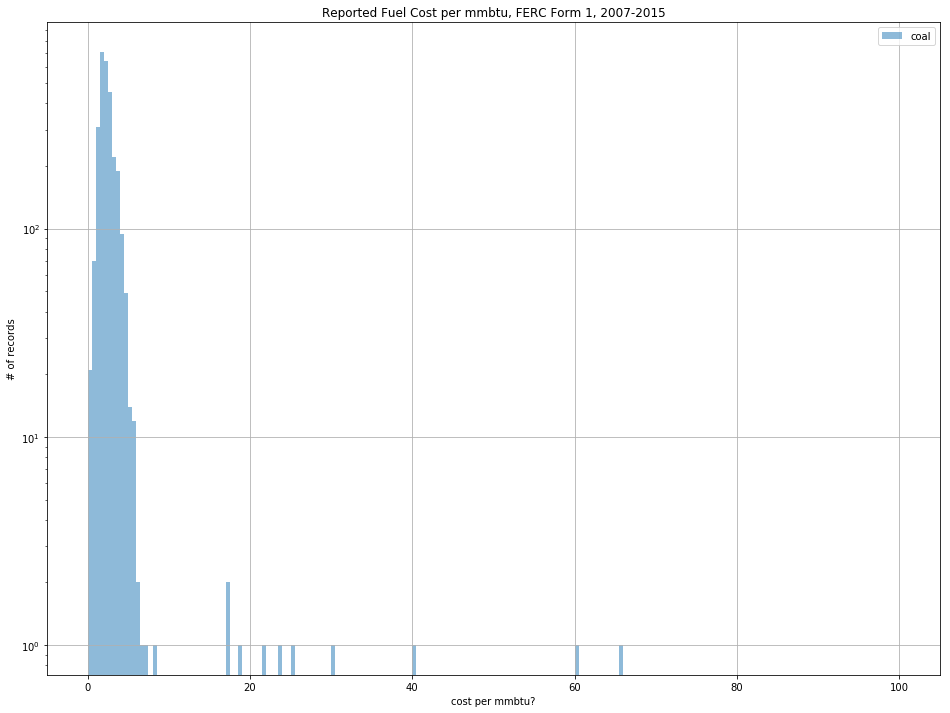

In [47]:
coal_no_zero = coal[coal.fuel_cost_per_mmbtu > 0]

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal_no_zero.fuel_cost_per_mmbtu], bins=200,alpha=.5,label=['coal'],log=True,range=(0,100))
plt.legend()
plt.show()

In [48]:
coal_no_zero.shape

(2935, 13)

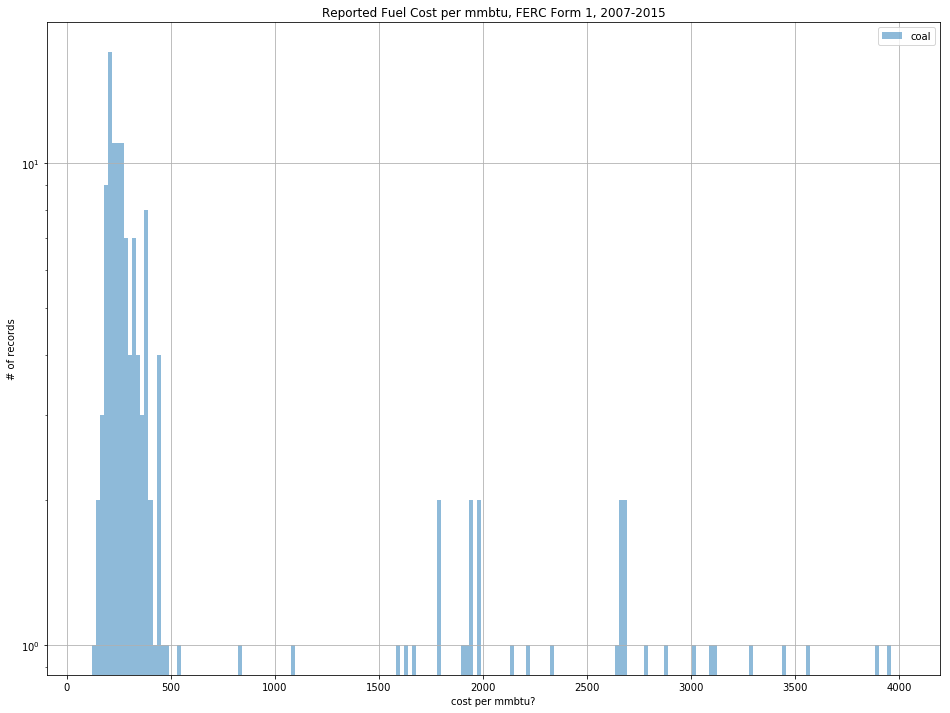

In [729]:
coal_no_zero = coal[coal.fuel_cost_per_mmbtu > 0]

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal_no_zero.fuel_cost_per_mmbtu], bins=200,alpha=.5,label=['coal'],log=True,range=(100,4000))
plt.legend()
plt.show()

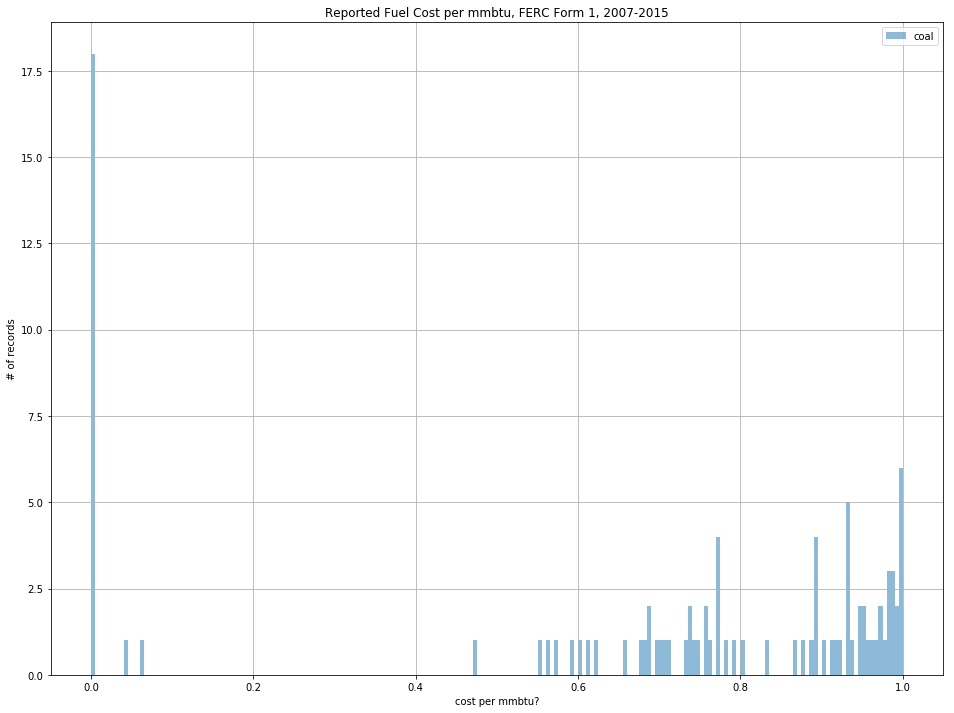

In [730]:
coal_no_zero = coal[coal.fuel_cost_per_mmbtu > 0]

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal_no_zero.fuel_cost_per_mmbtu], bins=200,alpha=.5,label=['coal'],range=(0,1))
plt.legend()
plt.show()

In [746]:
coal_no_zero.describe()

,id,respondent_id,report_year,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
count,2935.000000,2935.000000,2935.000000,2.935000e+03,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000,2935.000000
mean,6048.927428,120.209881,2010.868484,1.664266e+06,1.696540,85.464521,61.402941,39.461056,430.017717,32.086815
std,3508.190219,79.674660,2.530606,2.086134e+06,5.399622,1120.451938,812.434698,274.910531,1814.304853,520.185699
min,1.000000,1.000000,2007.000000,1.000000e+00,0.000000,0.000000,0.000000,0.001000,-325.000000,-18.832766
25%,3013.000000,55.000000,2009.000000,4.382040e+05,0.008657,31.461500,28.842000,1.761500,18.000000,9.625906
50%,6045.000000,127.000000,2011.000000,9.837380e+05,0.010614,43.107000,41.020000,2.275000,24.000000,10.316000
75%,9007.000000,177.000000,2013.000000,2.089440e+06,0.012080,63.058000,61.036000,3.000000,35.000000,10.912000
max,12256.000000,454.000000,2015.000000,4.641185e+07,28.722197,44033.320000,44033.320000,4181.493000,29179.000000,14033.000000


In [744]:
coal_no_zero.sort_values(by='fuel_cost_per_mmbtu',inplace=True)
coal_no_zero.head(40)

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,id,respondent_id,plant_name,report_year,fuel,fuel_unit,fuel_qty_burned,fuel_avg_mmbtu_per_unit,fuel_cost_per_unit_burned,fuel_cost_per_unit_delivered,fuel_cost_per_mmbtu,fuel_cost_per_mwh,fuel_mmbtu_per_mwh
1602,1603,130,Sooner,2008,coal,ton,4510024.0,17.584000,19.349,0.000,0.001,11.0,10.299000
1605,1606,130,Muskogee,2008,coal,ton,5836557.0,17.582000,20.920,0.000,0.001,18.0,10.459000
1055,1056,130,Sooner,2007,coal,ton,3780090.0,0.017590,19.708,0.000,0.001,11.0,10.238000
1058,1059,130,Muskogee,2007,coal,ton,4998369.0,0.017577,20.719,0.000,0.001,12.0,10.495000
8085,8086,130,Sooner,2012,coal,ton,3570879.0,17.553167,39.907,0.000,0.002,25.0,10.881000
8533,8534,130,Sooner,2013,coal,ton,3687724.0,17.518500,38.633,0.000,0.002,24.0,10.831000
8087,8088,130,Muskogee,2012,coal,ton,5031695.0,17.540858,35.202,0.000,0.002,22.0,11.177000
8535,8536,130,Muskogee,2013,coal,ton,4191162.0,17.568345,36.118,0.000,0.002,22.0,10.825000
12255,12256,130,Muskogee,2015,coal,ton,2923385.0,17.343169,36.375,0.000,0.002,23.0,11.130000
6470,6471,130,Muskogee,2011,coal,ton,5321781.0,17.640000,32.789,0.000,0.002,20.0,10.831000


In [728]:
coal_no_zero.sort_values(by='fuel_cost_per_mmbtu',inplace=True)
coal_no_zero.fuel_cost_per_mmbtu.tail(100)

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


3717      229.012
3715      229.706
6596      233.031
1981      237.676
7120      240.040
5146      241.891
8109      242.334
12196     242.663
5148      245.643
10697     246.926
8107      249.309
1980      252.013
10699     252.335
6598      255.883
6588      256.327
9609      259.161
6590      259.381
6485      260.273
1310      260.723
2997      261.283
12096     261.307
10838     262.326
2998      265.754
9549      270.843
12204     274.886
10843     276.980
8126      277.100
5150      277.418
6484      277.829
754       280.887
           ...   
1066     1592.752
1072     1638.672
3628     1663.128
2043     1781.562
3622     1789.611
4468     1896.768
2037     1917.498
4463     1941.204
4495     1941.405
4497     1972.855
4470     1979.429
4478     2136.429
3710     2213.367
4476     2323.165
4483     2637.828
6695     2662.647
6706     2664.418
6697     2686.345
6708     2688.715
6683     2787.361
6701     2884.044
10590    3020.000
6716     3097.761
4461     3117.243
6699     3

### Define a function for coal cost per mmbtu cleaning

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


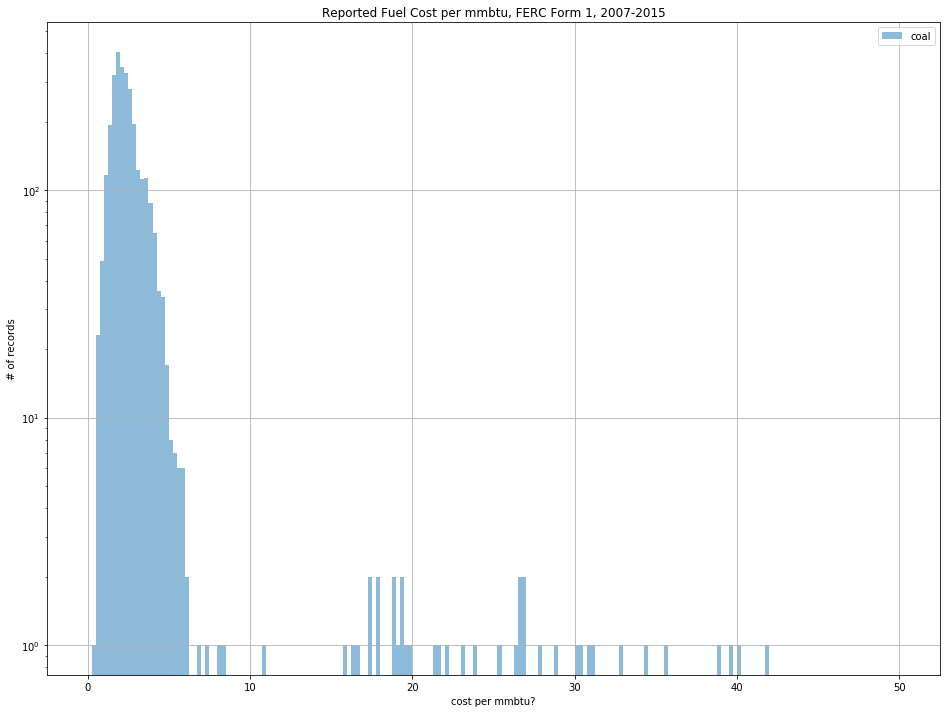

In [72]:
def coal_cost_per_mmbtu_correct(coal_df):
    
    coal_df = coal_df[coal_df.fuel_cost_per_mmbtu > 0]
    
    df_copy = coal_df.copy()
# convert cents per MMBTU to dollars per MMBTU
    df_cents_to_dollars = df_copy[(df_copy.fuel_cost_per_mmbtu > 50) & \
                      (df_copy.fuel_cost_per_mmbtu < 7500)]
    df_cents_to_dollars.fuel_cost_per_mmbtu = df_cents_to_dollars.fuel_cost_per_mmbtu.apply(lambda x:x / 100)
# convert dollars per pound to dollars per ton    
    small_df = df_copy[(df_copy.fuel_cost_per_mmbtu > .0005) & \
                      (df_copy.fuel_cost_per_mmbtu < .075)]
    small_df.fuel_cost_per_mmbtu = small_df.fuel_cost_per_mmbtu.apply(lambda x: x * 2000)
    
    coal_df = coal_df.drop(coal_df[(coal_df.fuel_cost_per_mmbtu > 50) & \
                      (coal_df.fuel_cost_per_mmbtu < 7500)].index)
    
    coal_df = coal_df.drop(coal_df[(coal_df.fuel_cost_per_mmbtu > .0005) & \
                      (coal_df.fuel_cost_per_mmbtu < .075)].index)

    coal_df = coal_df.append(df_cents_to_dollars)
    coal_df = coal_df 
    
    return coal_df

coal_cost_per_mmbtu_correct_1 = coal_cost_per_mmbtu_correct(coal)

fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal_cost_per_mmbtu_correct_1.fuel_cost_per_mmbtu], bins=200,alpha=.5,label=['coal'],range=(0,50), log=True)
plt.legend()
plt.show()


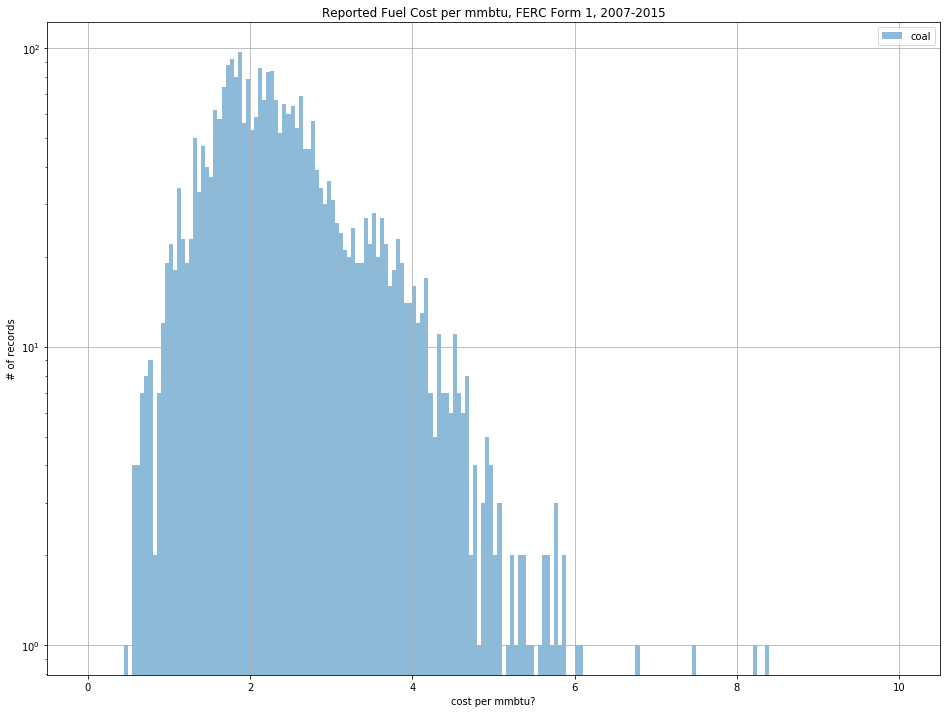

In [73]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal_cost_per_mmbtu_correct_1.fuel_cost_per_mmbtu], bins=200,alpha=.5,label=['coal'],range=(0,10), log=True)
plt.legend()
plt.show()

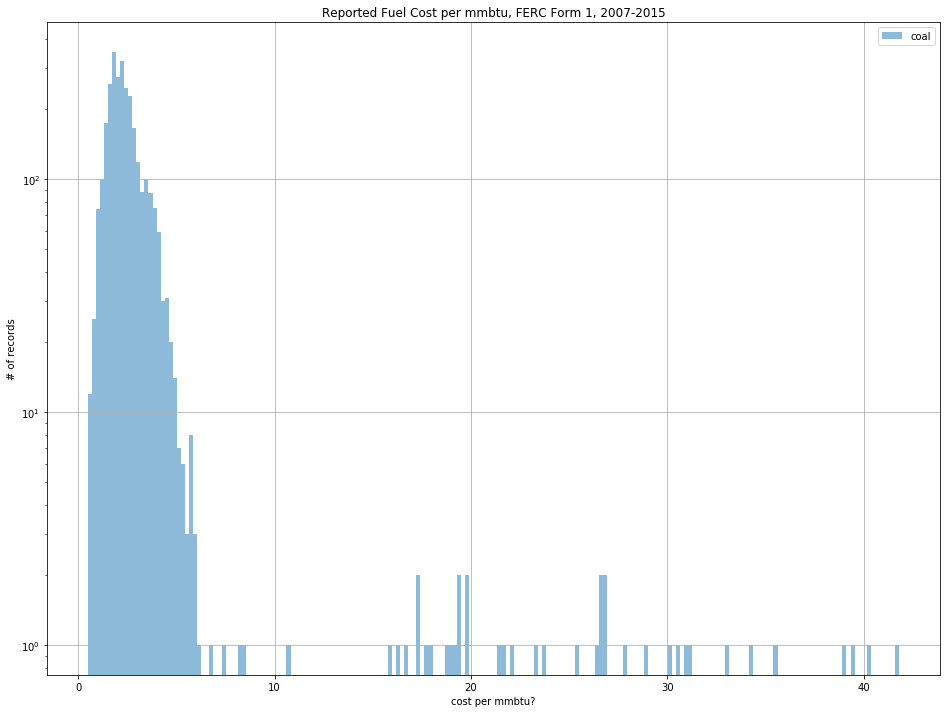

In [74]:
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Fuel Cost per mmbtu, FERC Form 1, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist([coal_cost_per_mmbtu_correct_1.fuel_cost_per_mmbtu], bins=200,alpha=.5,label=['coal'], log=True)
plt.legend()
plt.show()

In [741]:
coal_cost_per_mmbtu_correct_1.sort_values(by='fuel_cost_per_mmbtu',inplace=True)
coal_cost_per_mmbtu_correct_1.fuel_cost_per_mmbtu.head(40)

1602     0.00100
1605     0.00100
1055     0.00100
1058     0.00100
8085     0.00200
8533     0.00200
8087     0.00200
8535     0.00200
12255    0.00200
6470     0.00200
10022    0.00200
5032     0.00200
10024    0.00200
5034     0.00200
2872     0.00200
12253    0.00200
6468     0.00200
2869     0.00200
114      0.47100
2808     0.55000
118      0.56300
2810     0.57300
1231     0.59000
116      0.60300
676      0.60480
1229     0.61000
1425     0.62300
2388     0.65606
136      0.65800
1423     0.67500
2215     0.68000
4296     0.68700
155      0.69000
4926     0.70000
4186     0.70200
4184     0.70700
946      0.71400
4094     0.73200
1587     0.73600
10628    0.73900
Name: fuel_cost_per_mmbtu, dtype: float64

### Look at EIA BIT and LIG cost as a comparison.

In [757]:
eia_fuel = pd.read_sql('''SELECT * \
                                FROM fuel_receipts_costs_eia923 ''', pudl_engine)

eia_fuel

,fuel_receipt_id,plant_id,year,month,contract_type,contract_expiration_date,energy_source,coalmine_id,supplier,fuel_quantity,average_heat_content,average_sulfur_content,average_ash_content,average_mercury_content,fuel_cost,primary_transportation_mode,secondary_transportation_mode,natural_gas_transport
0,1,3,2011,1,C,1211.0,BIT,None,NAME PENDING,24076.0,22.660,0.59,6.2,NaN,544.4,RV,None,F
1,2,3,2011,1,C,1213.0,BIT,None,INTEROCEAN COAL,151180.0,22.660,0.59,6.2,NaN,404.4,RV,None,F
2,3,3,2011,1,S,NaN,NG,None,VARIOUS (NATURAL GAS SPOT PURCHASES ONLY),3645148.0,1.020,0.00,0.0,NaN,479.7,PL,None,F
3,4,3,2011,1,S,NaN,NG,None,VARIOUS (NATURAL GAS SPOT PURCHASES ONLY),39546.0,1.019,0.00,0.0,NaN,473.9,PL,None,F
4,5,7,2011,1,C,1217.0,BIT,None,ALABAMA COAL,4281.0,20.740,1.67,10.3,NaN,378.3,TR,None,None
5,6,7,2011,1,S,NaN,NG,None,VARIOUS,146973.0,1.011,0.00,0.0,NaN,488.0,PL,None,F
6,7,8,2011,1,C,1211.0,BIT,None,ALABAMA COAL,49397.0,24.720,1.12,11.4,NaN,454.4,TR,None,F
7,8,8,2011,1,C,1215.0,BIT,None,ALABAMA COAL,27473.0,24.016,1.92,13.9,NaN,299.0,TR,None,F
8,9,8,2011,1,C,1213.0,BIT,None,NAME PENDING,8959.0,22.074,1.07,14.9,NaN,356.7,RV,None,F
9,10,8,2011,1,C,1211.0,BIT,None,TUSCALOOSA RESOURCES,44066.0,24.850,1.05,11.9,NaN,460.4,RV,None,F


In [762]:
eia_fuel.energy_source.value_counts()

NG     98508
BIT    53019
SUB    30343
DFO    16196
WC      2804
RFO     1829
LIG     1265
PC      1068
OG       585
WO       277
KER      234
BFG      110
PG        50
JF        37
SGP       19
Name: energy_source, dtype: int64

In [767]:
eia_coal = eia_fuel[(eia_fuel['energy_source'] =='BIT') | (eia_fuel['energy_source']=='SUB')]

/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:583: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= mn)
/Users/Nannerz/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:584: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= mx)


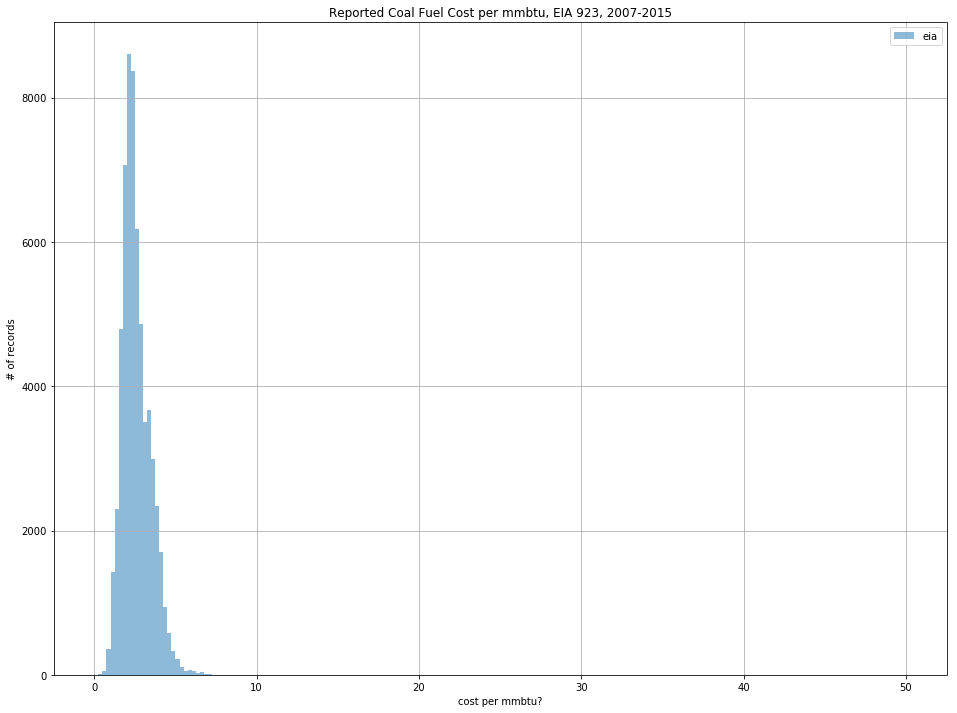

In [787]:
eia_coal_fuel_cost = eia_coal.fuel_cost / 100
fig = plt.figure(figsize=(16,12))
plt.grid()
plt.title("Reported Coal Fuel Cost per mmbtu, EIA 923, 2007-2015")
plt.ylabel("# of records")
plt.xlabel("cost per mmbtu?")
plt.hist(eia_coal_fuel_cost, bins=200,alpha=.5,label=['eia'],range=(0,50))
plt.legend()
plt.show()

In [788]:
eia_coal_fuel_cost.max()

32.670000000000002